## C-M(-C) comparison of data and methods ##

In [1]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa

import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
import csv

# import our own small lib. I access this one through PyCharm
import nsidc

In [2]:
#2. OPEN THE AVAILABLE DATASETS FOR 2010

# 25 km data
ds_37ghz_25km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
ds_37ghz_25km_H_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_D\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-D_2010.nc')
# ds_37ghz_25km_V_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_V_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36V-A_2010.nc')
# ds_37ghz_25km_V_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_V_D\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36V-D_2010.nc')
# ds_89ghz_3km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\89ghz_3km_H_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-89H-A_2010.nc')
# ds_89ghz_3km_V_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\89ghz_3km_V_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-89V-A_2010.nc')

# 3.125 km data
ds_37ghz_3km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_3km_H_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-36H-A_2010.nc')
ds_37ghz_3km_H_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_3km_H_D\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-36H-D_2010.nc')

ds = ds_37ghz_25km_H_D

# CHIRPS rainfall data 
path = ("C:\\Users\\908138\\githubdata\\chirps\\box_bonou\\box_bonou_mean_2010.csv")
# ds_p = pd.read_csv(path)
# ds_p.to_xarray()
ds_p = pd.read_csv(path, index_col='date',names=['date','precipitation'], skiprows=1)
precipitation = ds_p['precipitation']
# ds_p

# TEMPERATURE DATA
path_temp = ("C:\\Users\\908138\\githubdata\\temperature\\bohicon\\t_bohicon_daily_2010.csv")
ds_temp = pd.read_table(path_temp,sep=';')
temperature = ds_temp['TAVG']

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


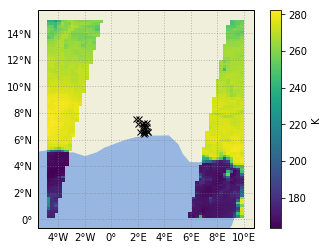

In [3]:
#3. POINTS OF INTEREST

# The following dataset satellite images of a certain region with specific settings (37GHz band, Horizontal Polarization, Ascending recording )
# ds = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
# get a mesh of the coordinates in grid's projection
xi, yi = np.meshgrid(ds.x, ds.y)

# the chosen projection is not (yet) supported by caropy.crs, so we need to do the transformation ourselves for now. 
# No biggy, here we go

# define the proj4string belonging to the grids you are downloading. You can find these in a downloaded sample 
# under the variable/attribute crs.proj4text. Here we simply copy-paste that.
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)
# now drape the data on the map
p = ax.pcolormesh(loni, lati, ds['TB'][1].values, transform=ccrs.PlateCarree())

# Ouémé delta 3 point calibration method - this is the current method that I'm testing.
points_interest = [(2.4526, 6.4365),  # Bonou - wet            #original (2.43, 6.43) #wet calibration - always covered in water (lake Nokoué)             
                   (2.69936, 6.90851),# Bonou - dry            #(2.6386, 6.8748), #original (2.69936, 6.90851), #bonou dry calibration
                   (2.4334, 6.8748),  # Bonou - measurement    #good results(2.4334, 6.8748) #original(2.44936, 6.90851) #bonou measurement cell
                  ## so far the final input
#                    (2.42135, 6.4365), #wet - 3
#                    (2.39010, 6.4365), #wet
#                    (2.48385, 6.4365), #wet
#                    (2.51510, 6.4365), #wet
#                    (2.4526, 6.46775), #wet
#                    (2.4526, 6.40525), #wet
#                    (2.48061, 6.90851), #dry
#                    (2.51186, 6.90851), #dry
#                    (2.54311, 6.90851), #dry
#                    (2.57436, 6.90851), #dry
#                    (2.60561, 6.90851), #dry
#                    (2.63686, 6.90851), #dry
#                    (2.66811, 6.90851), #dry
#                    (2.69936, 6.90851), #dry
#                    (2.44936, 6.90851), #measurement original
#                    (2.41811, 6.93976), #measurement
#                    (2.44936, 6.93976), #measurement
#                    (2.41811, 6.90851), #measurement
#                    (2.41811, 6.87726), #measurement
#                    (2.44936, 6.87726)  #measurement - 22
                   (2.1338, 7.5623),    #3  Atcherigbe - dry 
                   (1.8838, 7.5623),    #4  Atcherigbe - measurement 
                   (2.04597, 7.19790),  #5  Dome - dry
                   (2.29597, 7.19790),  #6  Dome - measurement
                   (2.72394, 7.21446),  #7  Ahlan - dry
                   (2.47394, 7.21446),  #8  Ahlan - measurement 
                   (2.72073, 6.67188),  #9  Adjohoun - dry
                   (2.47073, 6.67188),  #10 Adjohoun - measurement
                   (2.7532, 6.5838),    #11 Hetin-Sota - dry
                   (2.5032, 6.5838),    #12 Hetin-Sota - measurement
                   (2.7532, 6.5838),    #13 Aguegues - dry NOTE USES DRY CALIBRATION #11
                   (2.54800, 6.49183),  #14 Aguegues - measurement
                   (2.2069, 6.5685),    #15 So-Ava - dry NOTE 25 KM WEST AND NORTH
                   (2.3932, 6.5081),    #16 So-Ava - measurement
                   (2.6556, 7.0010),    #17 Junction - dry
                   (2.4056, 7.0010),    #18 Junction - measurement
                  ]

#Bonou - 2012-2018
# Dome - toutes les années
# Atcherigbe
# Save
# Adjohoun,
# Hetin-Sota,
# So-Ava,
# Abomey-Calawi



#Some coding to visualise the area. 
ax = plt.axes(projection=ccrs.PlateCarree())
ax = nsidc.plot_points(ax, points_interest, marker='x', color='k', linewidth=0., transform=ccrs.PlateCarree())
plt.colorbar(p, label='K')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Gracefully close ds
ds.close()

In [4]:
#4. COORDINATE SYSTEM PROJECTIONS
#Transforming the coordinate system. The data is available from a Measures dataset by NASA with a weird projection system
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'

# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)


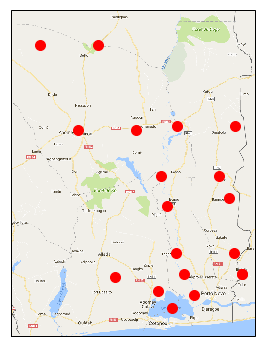

In [5]:
# 5.VISUALISE POINTS OF INTEREST
# first have a look at the points
osm_tiles = moa()
x, y = zip(*points_interest)

plt.figure(figsize=(6, 6))

# Use the tile's projection for the underlying map.
ax = plt.axes(projection=osm_tiles.crs)

# Add the tiles at zoom level 10.
ax.add_image(osm_tiles, 10)
ax.plot(x, y, color='r', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree())

plt.show()

In [6]:
# print(osm_tiles)
# points_interest

# Loading Brightness Temperature Data 2010

In [7]:
#6. LOAD AND MODIFY TB (BRIGHTNESS TEMPERATURE) TIMESERIES

points_x, points_y = zip(*points_xy)

# Loading the data in x-y coordinates
ts_37ghz_3km_H_D = ds_37ghz_3km_H_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_3km_H_A = ds_37ghz_3km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_25km_H_A = ds_37ghz_25km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_H_D = ds_37ghz_25km_H_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_25km_V_A = ds_37ghz_25km_V_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_25km_V_D = ds_37ghz_25km_V_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')

#----------values_37ghz_25km_H_D----------------------------------------------------------------------------------
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
values_37ghz_25km_H_D = ts_37ghz_25km_H_D['TB'].values
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))

TB_37ghz_25km_H_D_wet= pd.DataFrame(values_37ghz_25km_H_D[0])
TB_37ghz_25km_H_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma = TB_37ghz_25km_H_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet

TB_37ghz_25km_H_D_dry= pd.DataFrame(values_37ghz_25km_H_D[1])
TB_37ghz_25km_H_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma = TB_37ghz_25km_H_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement= pd.DataFrame(values_37ghz_25km_H_D[2])
TB_37ghz_25km_H_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma = TB_37ghz_25km_H_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#----------values_37ghz_3km_H_D----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_37ghz_3km_H_D = ts_37ghz_3km_H_D['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_37ghz_3km_H_D_wet= pd.DataFrame(values_37ghz_3km_H_D[0])
TB_37ghz_3km_H_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma = TB_37ghz_3km_H_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_37ghz_3km_H_D_dry= pd.DataFrame(values_37ghz_3km_H_D[1])
TB_37ghz_3km_H_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma = TB_37ghz_3km_H_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement= pd.DataFrame(values_37ghz_3km_H_D[2])
TB_37ghz_3km_H_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma = TB_37ghz_3km_H_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

#----------Atcherigbe----------------------------------------------------------------------------------
#25km
TB_37ghz_25km_H_D_dry_atcherigbe= pd.DataFrame(values_37ghz_25km_H_D[3])
TB_37ghz_25km_H_D_dry_atcherigbe.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma_atcherigbe = TB_37ghz_25km_H_D_dry_atcherigbe.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement_atcherigbe= pd.DataFrame(values_37ghz_25km_H_D[4])
TB_37ghz_25km_H_D_measurement_atcherigbe.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_atcherigbe = TB_37ghz_25km_H_D_measurement_atcherigbe.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#3km
TB_37ghz_3km_H_D_dry_atcherigbe= pd.DataFrame(values_37ghz_3km_H_D[3])
TB_37ghz_3km_H_D_dry_atcherigbe.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_atcherigbe = TB_37ghz_3km_H_D_dry_atcherigbe.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement_atcherigbe= pd.DataFrame(values_37ghz_3km_H_D[4])
TB_37ghz_3km_H_D_measurement_atcherigbe.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_atcherigbe = TB_37ghz_3km_H_D_measurement_atcherigbe.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

#----------Dome----------------------------------------------------------------------------------
#25km
TB_37ghz_25km_H_D_dry_dome= pd.DataFrame(values_37ghz_25km_H_D[5])
TB_37ghz_25km_H_D_dry_dome.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma_dome = TB_37ghz_25km_H_D_dry_dome.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement_dome= pd.DataFrame(values_37ghz_25km_H_D[6])
TB_37ghz_25km_H_D_measurement_dome.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_dome = TB_37ghz_25km_H_D_measurement_dome.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#3km
TB_37ghz_3km_H_D_dry_dome= pd.DataFrame(values_37ghz_3km_H_D[5])
TB_37ghz_3km_H_D_dry_dome.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_dome = TB_37ghz_3km_H_D_dry_dome.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement_dome= pd.DataFrame(values_37ghz_3km_H_D[6])
TB_37ghz_3km_H_D_measurement_dome.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_dome = TB_37ghz_3km_H_D_measurement_dome.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

#----------Ahlan----------------------------------------------------------------------------------
#25km
TB_37ghz_25km_H_D_dry_ahlan= pd.DataFrame(values_37ghz_25km_H_D[7])
TB_37ghz_25km_H_D_dry_ahlan.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma_ahlan = TB_37ghz_25km_H_D_dry_ahlan.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement_ahlan= pd.DataFrame(values_37ghz_25km_H_D[8])
TB_37ghz_25km_H_D_measurement_ahlan.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_ahlan = TB_37ghz_25km_H_D_measurement_ahlan.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#3km
TB_37ghz_3km_H_D_dry_ahlan= pd.DataFrame(values_37ghz_3km_H_D[7])
TB_37ghz_3km_H_D_dry_ahlan.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_ahlan = TB_37ghz_3km_H_D_dry_ahlan.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement_ahlan= pd.DataFrame(values_37ghz_3km_H_D[8])
TB_37ghz_3km_H_D_measurement_ahlan.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_ahlan = TB_37ghz_3km_H_D_measurement_ahlan.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

#----------Adjohoun----------------------------------------------------------------------------------
#25km
TB_37ghz_25km_H_D_dry_adjohoun= pd.DataFrame(values_37ghz_25km_H_D[9])
TB_37ghz_25km_H_D_dry_adjohoun.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma_adjohoun = TB_37ghz_25km_H_D_dry_adjohoun.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement_adjohoun= pd.DataFrame(values_37ghz_25km_H_D[10])
TB_37ghz_25km_H_D_measurement_adjohoun.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_adjohoun = TB_37ghz_25km_H_D_measurement_adjohoun.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#3km
TB_37ghz_3km_H_D_dry_adjohoun= pd.DataFrame(values_37ghz_3km_H_D[9])
TB_37ghz_3km_H_D_dry_adjohoun.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_adjohoun = TB_37ghz_3km_H_D_dry_adjohoun.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement_adjohoun= pd.DataFrame(values_37ghz_3km_H_D[10])
TB_37ghz_3km_H_D_measurement_adjohoun.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_adjohoun = TB_37ghz_3km_H_D_measurement_adjohoun.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurementadjohoun

#----------Hetin-Sota----------------------------------------------------------------------------------
#25km
TB_37ghz_25km_H_D_dry_hetin_sota= pd.DataFrame(values_37ghz_25km_H_D[11])
TB_37ghz_25km_H_D_dry_hetin_sota.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma_hetin_sota = TB_37ghz_25km_H_D_dry_hetin_sota.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement_hetin_sota= pd.DataFrame(values_37ghz_25km_H_D[12])
TB_37ghz_25km_H_D_measurement_hetin_sota.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_hetin_sota = TB_37ghz_25km_H_D_measurement_hetin_sota.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#3km
TB_37ghz_3km_H_D_dry_hetin_sota= pd.DataFrame(values_37ghz_3km_H_D[11])
TB_37ghz_3km_H_D_dry_hetin_sota.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_hetin_sota = TB_37ghz_3km_H_D_dry_hetin_sota.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement_hetin_sota= pd.DataFrame(values_37ghz_3km_H_D[12])
TB_37ghz_3km_H_D_measurement_hetin_sota.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_hetin_sota = TB_37ghz_3km_H_D_measurement_hetin_sota.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

#----------Aguegues----------------------------------------------------------------------------------
#25km
TB_37ghz_25km_H_D_dry_aguegues= pd.DataFrame(values_37ghz_25km_H_D[13])
TB_37ghz_25km_H_D_dry_aguegues.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma_aguegues = TB_37ghz_25km_H_D_dry_aguegues.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement_aguegues= pd.DataFrame(values_37ghz_25km_H_D[14])
TB_37ghz_25km_H_D_measurement_aguegues.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_aguegues = TB_37ghz_25km_H_D_measurement_aguegues.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#3km
TB_37ghz_3km_H_D_dry_aguegues= pd.DataFrame(values_37ghz_3km_H_D[13])
TB_37ghz_3km_H_D_dry_aguegues.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_aguegues = TB_37ghz_3km_H_D_dry_aguegues.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement_aguegues= pd.DataFrame(values_37ghz_3km_H_D[14])
TB_37ghz_3km_H_D_measurement_aguegues.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_aguegues = TB_37ghz_3km_H_D_measurement_aguegues.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

#----------So-Ava----------------------------------------------------------------------------------
#25km
TB_37ghz_25km_H_D_dry_so_ava= pd.DataFrame(values_37ghz_25km_H_D[15])
TB_37ghz_25km_H_D_dry_so_ava.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma_so_ava = TB_37ghz_25km_H_D_dry_so_ava.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement_so_ava= pd.DataFrame(values_37ghz_25km_H_D[16])
TB_37ghz_25km_H_D_measurement_so_ava.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_so_ava = TB_37ghz_25km_H_D_measurement_so_ava.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#3km
TB_37ghz_3km_H_D_dry_so_ava= pd.DataFrame(values_37ghz_3km_H_D[15])
TB_37ghz_3km_H_D_dry_so_ava.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_so_ava = TB_37ghz_3km_H_D_dry_so_ava.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement_so_ava= pd.DataFrame(values_37ghz_3km_H_D[16])
TB_37ghz_3km_H_D_measurement_so_ava.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_so_ava = TB_37ghz_3km_H_D_measurement_so_ava.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

#----------Junction----------------------------------------------------------------------------------
#25km
TB_37ghz_25km_H_D_dry_junction= pd.DataFrame(values_37ghz_25km_H_D[17])
TB_37ghz_25km_H_D_dry_junction.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma_junction = TB_37ghz_25km_H_D_dry_junction.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement_junction= pd.DataFrame(values_37ghz_25km_H_D[18])
TB_37ghz_25km_H_D_measurement_junction.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_junction = TB_37ghz_25km_H_D_measurement_junction.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#3km
TB_37ghz_3km_H_D_dry_junction= pd.DataFrame(values_37ghz_3km_H_D[17])
TB_37ghz_3km_H_D_dry_junction.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_junction = TB_37ghz_3km_H_D_dry_junction.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement_junction= pd.DataFrame(values_37ghz_3km_H_D[18])
TB_37ghz_3km_H_D_measurement_junction.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_junction = TB_37ghz_3km_H_D_measurement_junction.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

print('done')

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  if __name__ == '__main__':


done


# WET CALIBRATION VS. DRY CALIBRATION VS. MEASUREMENT CELL

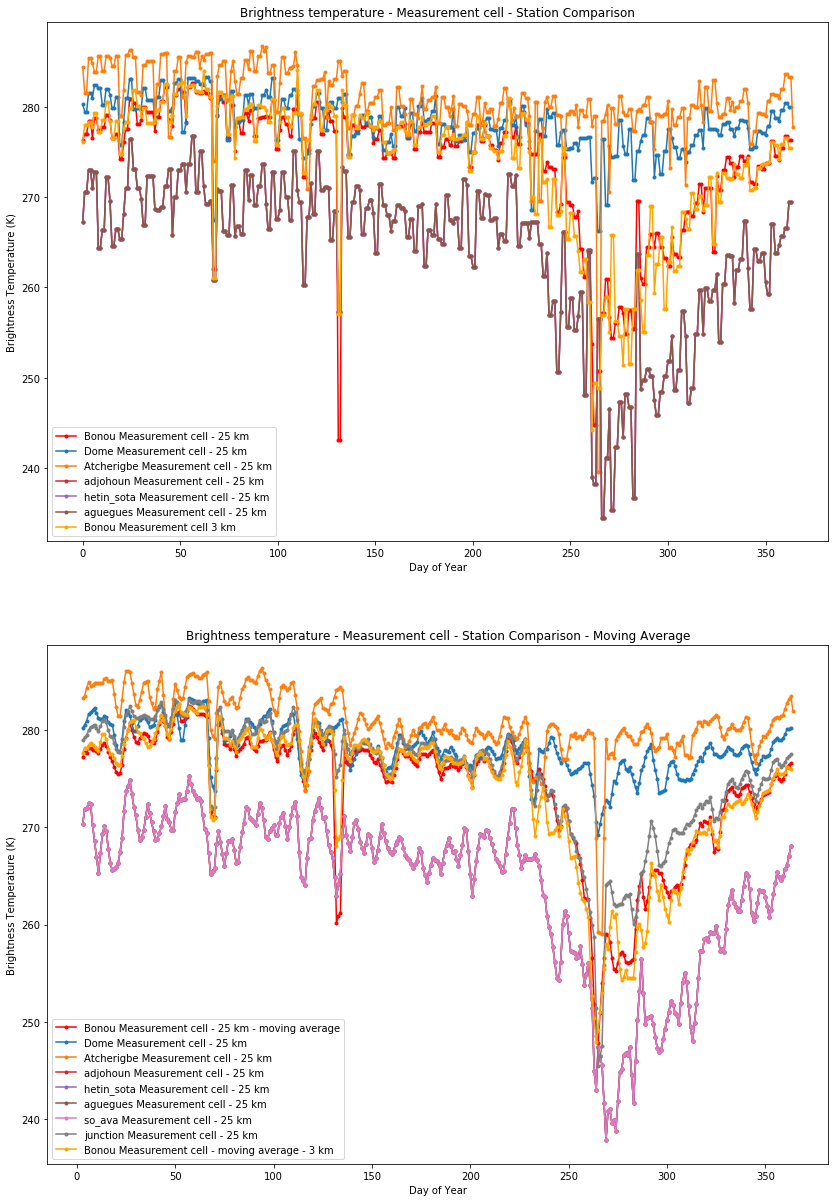

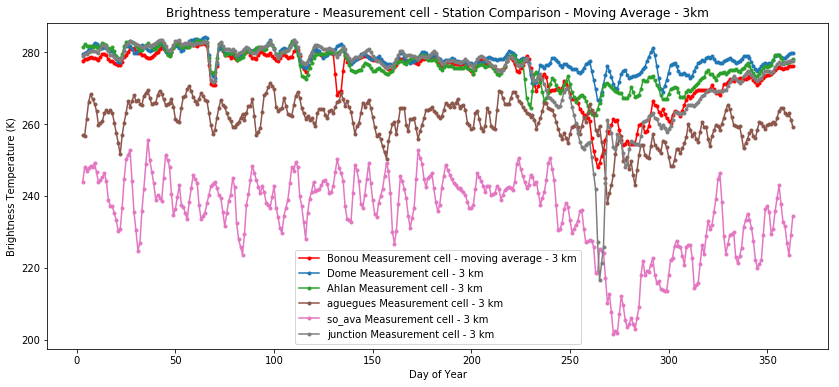

In [15]:
# PLOT WET CALIBRATION VS. DRY CALIBRATION VS. MEASUREMENT CELL


#----------MEASUREMENT CELLS - ORIGINAL----------------------------------------------------------------------------------------
fig = plt.figure(figsize=(14,21))
ax1 = fig.add_subplot(211) 
plt.title('Brightness temperature - Measurement cell - Station Comparison')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
# 25 km data
ax1.plot(TB_37ghz_25km_H_D_measurement, marker='.', color='red', label = 'Bonou Measurement cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_dry, marker='.', color='green', label = 'Bonou Dry cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_wet, marker='.', color='blue', label = 'Wet cell - ')
ax1.plot(TB_37ghz_25km_H_D_measurement_dome, marker='.', color='C0', label = 'Dome Measurement cell - 25 km')
ax1.plot(TB_37ghz_25km_H_D_measurement_atcherigbe, marker='.', color='C1', label = 'Atcherigbe Measurement cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_measurement_ahlan, marker='.', color='C2', label = 'Ahlan Measurement cell - 25 km')
ax1.plot(TB_37ghz_25km_H_D_measurement_adjohoun, marker='.', color='C3', label = 'adjohoun Measurement cell - 25 km')
ax1.plot(TB_37ghz_25km_H_D_measurement_hetin_sota, marker='.', color='C4', label = 'hetin_sota Measurement cell - 25 km')
ax1.plot(TB_37ghz_25km_H_D_measurement_aguegues, marker='.', color='C5', label = 'aguegues Measurement cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_measurement_so_ava, marker='.', color='C6', label = 'so_ava Measurement cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_measurement_junction, marker='.', color='C7', label = 'junction Measurement cell - 25 km')
plt.legend(loc=2)

# 3 km data
ax1.plot(TB_37ghz_3km_H_D_measurement, marker='.', color='orange', label = 'Bonou Measurement cell 3 km')
# # ax1.plot(TB_37ghz_3km_H_D_dry, marker='.', color='green1', label = 'Bonou Dry cell - 3 km')
# # ax1.plot(TB_37ghz_3km_H_D_wet, marker='.', color='blue', label = 'Wet cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_dome, marker='.', color='C0', label = 'Dome Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_atcherigbe, marker='.', color='C1', label = 'Atcherigbe Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_ahlan, marker='.', color='C2', label = 'Ahlan Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_adjohoun, marker='.', color='C3', label = 'adjohoun Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_hetin_sota, marker='.', color='C4', label = 'hetin_sota Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_aguegues, marker='.', color='C5', label = 'aguegues Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_so_ava, marker='.', color='C6', label = 'so_ava Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_junction, marker='.', color='C7', label = 'junction Measurement cell - 3 km')
plt.legend(loc='best')
 
    
#----------MEASUREMENT CELLS - MOVING AVERAGE----------------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
ax2 = fig.add_subplot(212)
plt.title('Brightness temperature - Measurement cell - Station Comparison - Moving Average')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
# 25 km data
ax2.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='red', label = 'Bonou Measurement cell - 25 km - moving average')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green', label = 'Bonou Dry calibration - 25 km - moving average')
# ax2.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Wet calibration - moving average')
ax2.plot(TB_37ghz_25km_H_D_measurement_ma_dome, marker='.', color='C0', label = 'Dome Measurement cell - 25 km')
ax2.plot(TB_37ghz_25km_H_D_measurement_ma_atcherigbe, marker='.', color='C1', label = 'Atcherigbe Measurement cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_measurement_ma_ahlan, marker='.', color='C2', label = 'Ahlan Measurement cell - 25 km')
ax2.plot(TB_37ghz_25km_H_D_measurement_ma_adjohoun, marker='.', color='C3', label = 'adjohoun Measurement cell - 25 km')
ax2.plot(TB_37ghz_25km_H_D_measurement_ma_hetin_sota, marker='.', color='C4', label = 'hetin_sota Measurement cell - 25 km')
ax2.plot(TB_37ghz_25km_H_D_measurement_ma_aguegues, marker='.', color='C5', label = 'aguegues Measurement cell - 25 km')
ax2.plot(TB_37ghz_25km_H_D_measurement_ma_so_ava, marker='.', color='C6', label = 'so_ava Measurement cell - 25 km')
ax2.plot(TB_37ghz_25km_H_D_measurement_ma_junction, marker='.', color='C7', label = 'junction Measurement cell - 25 km')
plt.legend(loc=2)
# 3 km data
ax2.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='orange', label = 'Bonou Measurement cell - moving average - 3 km')
# # ax2.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='C5', label = 'Dry calibration - moving average - 3 km')
# # ax2.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='C6', label = 'Wet calibration - moving average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_measurement_ma_dome, marker='.', color='C0', label = 'Dome Measurement cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_measurement_ma_atcherigbe, marker='.', color='C1', label = 'Atcherigbe Measurement cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_measurement_ma_ahlan, marker='.', color='C2', label = 'Ahlan Measurement cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_measurement_ma_adjohoun, marker='.', color='C3', label = 'adjohoun Measurement cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_measurement_ma_hetin_sota, marker='.', color='C4', label = 'hetin_sota Measurement cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_measurement_ma_aguegues, marker='.', color='C5', label = 'aguegues Measurement cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_measurement_ma_so_ava, marker='.', color='C6', label = 'so_ava Measurement cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_measurement_ma_junction, marker='.', color='C7', label = 'junction Measurement cell - 3 km')
plt.legend(loc='best')
 

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(111)
plt.title('Brightness temperature - Measurement cell - Station Comparison - Moving Average - 3km')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
# 25 km data
# ax2.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='red', label = 'Bonou Measurement cell - 25 km - moving average')
# # ax2.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green', label = 'Bonou Dry calibration - 25 km - moving average')
# # ax2.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Wet calibration - moving average')
# ax2.plot(TB_37ghz_25km_H_D_measurement_ma_dome, marker='.', color='C0', label = 'Dome Measurement cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_measurement_ma_atcherigbe, marker='.', color='C1', label = 'Atcherigbe Measurement cell - 25 km')
# # ax2.plot(TB_37ghz_25km_H_D_measurement_ma_ahlan, marker='.', color='C2', label = 'Ahlan Measurement cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_measurement_ma_adjohoun, marker='.', color='C3', label = 'adjohoun Measurement cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_measurement_ma_hetin_sota, marker='.', color='C4', label = 'hetin_sota Measurement cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_measurement_ma_aguegues, marker='.', color='C5', label = 'aguegues Measurement cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_measurement_ma_so_ava, marker='.', color='C6', label = 'so_ava Measurement cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_measurement_ma_junction, marker='.', color='C7', label = 'junction Measurement cell - 25 km')
# plt.legend(loc=2)
# 3 km data
ax1.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='red', label = 'Bonou Measurement cell - moving average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='C5', label = 'Dry calibration - moving average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='C6', label = 'Wet calibration - moving average - 3 km')
ax1.plot(TB_37ghz_3km_H_D_measurement_ma_dome, marker='.', color='C0', label = 'Dome Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_ma_atcherigbe, marker='.', color='C1', label = 'Atcherigbe Measurement cell - 3 km')
ax1.plot(TB_37ghz_3km_H_D_measurement_ma_ahlan, marker='.', color='C2', label = 'Ahlan Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_ma_adjohoun, marker='.', color='C3', label = 'adjohoun Measurement cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_measurement_ma_hetin_sota, marker='.', color='C4', label = 'hetin_sota Measurement cell - 3 km')
ax1.plot(TB_37ghz_3km_H_D_measurement_ma_aguegues, marker='.', color='C5', label = 'aguegues Measurement cell - 3 km')
ax1.plot(TB_37ghz_3km_H_D_measurement_ma_so_ava, marker='.', color='C6', label = 'so_ava Measurement cell - 3 km')
ax1.plot(TB_37ghz_3km_H_D_measurement_ma_junction, marker='.', color='C7', label = 'junction Measurement cell - 3 km')
plt.legend(loc='best')    
    
    
    
    
    
# #----------DRY CELLS - ORIGINAL----------------------------------------------------------------------------------------
# fig = plt.figure(figsize=(14,21))
# ax1 = fig.add_subplot(211) 
# plt.title('Brightness temperature - Dry cell - Station Comparison')
# plt.xlabel('Day of Year')
# plt.ylabel('Brightness Temperature (K)')
# # 25 km data
# # ax1.plot(TB_37ghz_25km_H_D_measurement, marker='.', color='red', label = 'Bonou Measurement cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_dry, marker='.', color='green', label = 'Bonou Dry cell - 25 km')
# # ax1.plot(TB_37ghz_25km_H_D_wet, marker='.', color='blue', label = 'Wet cell - ')
# ax1.plot(TB_37ghz_25km_H_D_dry_dome, marker='.', color='C0', label = 'Dome dry cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_dry_atcherigbe, marker='.', color='C1', label = 'Atcherigbe dry cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_dry_ahlan, marker='.', color='C2', label = 'Ahlan dry cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_dry_adjohoun, marker='.', color='C3', label = 'adjohoun dry cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_dry_hetin_sota, marker='.', color='C4', label = 'hetin_sota dry cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_dry_aguegues, marker='.', color='C5', label = 'aguegues dry cell - 25 km')
# # ax1.plot(TB_37ghz_25km_H_D_dry_so_ava, marker='.', color='C6', label = 'so_ava dry cell - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_dry_junction, marker='.', color='C7', label = 'junction dry cell - 25 km')
# plt.legend(loc=2)

# # 3 km data
# # ax1.plot(TB_37ghz_3km_H_D_measurement, marker='.', color='orange', label = 'Bonou Measurement cell 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry, marker='.', color='pink', label = 'Bonou Dry cell - 3 km')
# # ax1.plot(TB_37ghz_3km_H_D_wet, marker='.', color='blue', label = 'Wet cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_dome, marker='.', color='C0', label = 'Dome dry cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_atcherigbe, marker='.', color='C1', label = 'Atcherigbe dry cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_ahlan, marker='.', color='C2', label = 'Ahlan dry cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_adjohoun, marker='.', color='C3', label = 'adjohoun dry cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_hetin_sota, marker='.', color='C4', label = 'hetin_sota dry cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_aguegues, marker='.', color='C5', label = 'aguegues dry cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_so_ava, marker='.', color='C6', label = 'so_ava dry cell - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_junction, marker='.', color='C7', label = 'junction dry cell - 3 km')
# plt.legend(loc='best')
 
    
# #----------DRY CELLS - MOVING AVERAGE----------------------------------------------------------------------------------------
# # plt.figure(figsize=(14,6))
# # values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
# ax2 = fig.add_subplot(212)
# plt.title('Brightness temperature - Dry cell - Station Comparison - Moving Average')
# plt.xlabel('Day of Year')
# plt.ylabel('Brightness Temperature (K)')
# # 25 km data
# # ax2.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='red', label = 'Bonou Measurement cell - 25 km - moving average')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green', label = 'Bonou Dry calibration - 25 km - moving average')
# # ax2.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Wet calibration - moving average')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma_dome, marker='.', color='C0', label = 'Dome dry cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma_atcherigbe, marker='.', color='C1', label = 'Atcherigbe dry cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma_ahlan, marker='.', color='C2', label = 'Ahlan dry cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma_adjohoun, marker='.', color='C3', label = 'adjohoun dry cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma_hetin_sota, marker='.', color='C4', label = 'hetin_sota dry cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma_aguegues, marker='.', color='C5', label = 'aguegues dry cell - 25 km')
# # ax2.plot(TB_37ghz_25km_H_D_dry_ma_so_ava, marker='.', color='C6', label = 'so_ava dry cell - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma_junction, marker='.', color='C7', label = 'junction dry cell - 25 km')
# plt.legend(loc=2)
# # 3 km data
# # ax2.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='orange', label = 'Bonou Measurement cell - moving average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='pink', label = 'Dry calibration - moving average - 3 km')
# # ax2.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='C6', label = 'Wet calibration - moving average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_dome, marker='.', color='C0', label = 'Dome dry cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_atcherigbe, marker='.', color='C1', label = 'Atcherigbe dry cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_ahlan, marker='.', color='C2', label = 'Ahlan dry cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_adjohoun, marker='.', color='C3', label = 'adjohoun dry cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_hetin_sota, marker='.', color='C4', label = 'hetin_sota dry cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_aguegues, marker='.', color='C5', label = 'aguegues dry cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_so_ava, marker='.', color='C6', label = 'so_ava dry cell - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_junction, marker='.', color='C7', label = 'junction dry cell - 3 km')
# plt.legend(loc='best')